# Spaceship Titanic: Predicting Transported Passengers

## Preparation

### Libraries

In [1]:
# Data plotting and handling
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing and metrics
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, RobustScaler
from sklearn.feature_selection import RFECV

# Binary Classifiers
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC


### Data

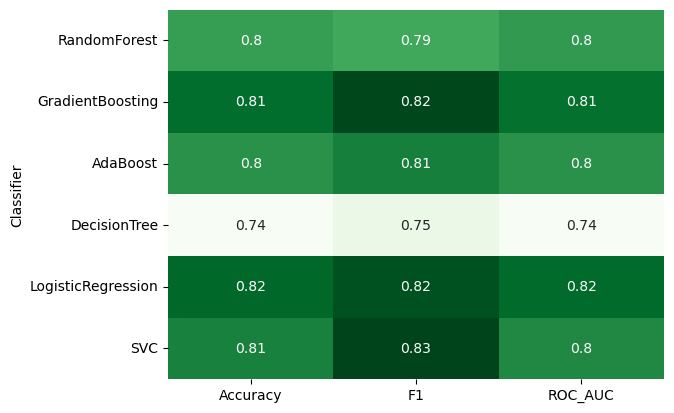

In [2]:
# Data importing
train_path = 'Data/train.csv'
titanic = pd.read_csv(train_path, index_col='PassengerId')

submission_path = 'Data/test.csv'
submission = pd.read_csv(submission_path, index_col='PassengerId')

cats = ['HomePlanet','Destination','Deck','Side']
nums_ints = ['Age']
nums_floats = ['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck']
bools = ['CryoSleep','VIP']

def titanic_transform(
        data : pd.DataFrame,
        step : int=1,
        median_age_train: pd.Series | float | int | None = None,
        median_expenses_train: pd.Series | float | int | None = None,
        scaler: RobustScaler | None = None,
        encoder_oh: OneHotEncoder | None = None,
        encoder_l: LabelEncoder | None = None,
        prediction: bool = False
        ) -> pd.DataFrame:
    if step not in [1,2]: raise Exception('Invalid step! Try step=1 or step=2.')
    if step == 1:
        # Split cabin into separate columns
        cabin_columns = ['Deck','CabinNumber','Side']
        data[cabin_columns] = (
            data['Cabin']
            .str
            .split('/', expand=True)
        )
        del data['Cabin']
        del data['CabinNumber']
        del data['Name']

        # Inferential null handling
        # Unknown categories will have their own category
        data[cats] = data[cats].fillna('Unknown')
        data[cats] = data[cats].astype('category')

        # Unknown booleans will be False or 0
        if prediction != True:
            data[bools] = data[bools].fillna(0)
            data[bools] = data[bools].astype(int)
        return data

    if step == 2:
        # Numeric null handling

        # Unknown ages will be filled with the median of training data (Slightly skewed)
        data['Age'] = data['Age'].fillna(median_age_train)
        data['Age'] = data['Age'].astype(int)

        # Unknown expenses will be filled with the medians of training data (Heavily skewed)
        data[nums_floats] = data[nums_floats].fillna(median_expenses_train)
        data[nums_floats] = data[nums_floats].astype(float)
    
        # Normalize and encode data
        data[nums_ints + nums_floats] = scaler.transform(data[nums_ints + nums_floats])
        data['Deck'] = encoder_l.transform(data['Deck'])
        encoded_data_oh = encoder_oh.transform(data[['HomePlanet','Destination','Side']])
        encoded_data_oh_df = pd.DataFrame(encoded_data_oh.toarray(), index=data.index, columns=encoder_oh.get_feature_names_out(['HomePlanet','Destination','Side']), dtype=int)
        data = pd.concat([data, encoded_data_oh_df], axis=1)

        # Delete old categorical data
        del data['HomePlanet']
        del data['Destination']
        del data['Side']

        return data


titanic = titanic_transform(titanic)
submission = titanic_transform(submission)
titanic['Transported'] = titanic['Transported'].astype(int)

# Train-test split
X = titanic.drop(columns='Transported')
y = titanic['Transported']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=132)

# Get the medians of numeric data
median_age_train = X_train['Age'].median()
median_expenses_train = X_train[nums_floats].median()

# Train scalers and encoders
scaler = RobustScaler()
scaler.fit(X_train[nums_ints + nums_floats])
encoder_oh = OneHotEncoder()
encoder_oh.fit(X_train[['HomePlanet','Destination','Side']])
encoder_l = LabelEncoder()
encoder_l.fit(X_train['Deck'])

X_train = titanic_transform(
    X_train,
    step = 2,
    median_age_train = median_age_train,
    median_expenses_train = median_expenses_train,
    scaler = scaler,
    encoder_oh = encoder_oh,
    encoder_l = encoder_l
)

X_test = titanic_transform(
    X_test,
    step = 2,
    median_age_train = median_age_train,
    median_expenses_train = median_expenses_train,
    scaler = scaler,
    encoder_oh = encoder_oh,
    encoder_l = encoder_l
)

submission = titanic_transform(
    submission,
    step = 2,
    median_age_train = median_age_train,
    median_expenses_train = median_expenses_train,
    scaler = scaler,
    encoder_oh = encoder_oh,
    encoder_l = encoder_l,
    prediction = True
)

classifiers = {
    'RandomForest': RandomForestClassifier(random_state=132),
    'GradientBoosting': GradientBoostingClassifier(random_state=132),
    'AdaBoost': AdaBoostClassifier(random_state=132),
    'DecisionTree': DecisionTreeClassifier(random_state=132),
    'LogisticRegression': LogisticRegression(random_state=132, max_iter=1000),
    'SVC': SVC(random_state=132)
}

scores = {
    'Classifier':[],
    'Accuracy':[],
    'F1':[],
    'ROC_AUC':[]
}

for cname, cmodel in classifiers.items():
    cmodel.fit(X_train, y_train)
    y_pred = cmodel.predict(X_test)
    scores['Classifier'].append(cname)
    scores['Accuracy'].append(accuracy_score(y_test, y_pred))
    scores['F1'].append(f1_score(y_test, y_pred))
    scores['ROC_AUC'].append(roc_auc_score(y_test, y_pred))

scores = pd.DataFrame(scores)
scores.set_index(scores['Classifier'], inplace=True)
scores.drop(columns='Classifier',axis=1,inplace=True)
sns.heatmap(scores, annot=True, cmap='Greens', cbar=False)
plt.show()


Model Chosen: **Logistic Regression**  
Reason: Highest ROC AUC score

In [3]:
model = RandomForestClassifier(random_state=132)
# Recursive Feature Elimination using Logistic Regression
rfe = RFECV(estimator=model, n_jobs=-1)
rfe.fit(X_train, y_train)

print(
    f'Optimal number of features: {rfe.n_features_}\n',
    f'Features kept:\n'
)
for i,col in zip(range(X_train.shape[1]),X_train.columns):
    if rfe.support_[i]:
        print(col)


Optimal number of features: 12
 Features kept:

CryoSleep
Age
RoomService
FoodCourt
ShoppingMall
Spa
VRDeck
Deck
HomePlanet_Earth
HomePlanet_Europa
Destination_TRAPPIST-1e
Side_S


In [4]:
# Transform data
X_train = rfe.transform(X_train)
X_test = rfe.transform(X_test)

print(X_train.shape, X_test.shape)

(6954, 12) (1739, 12)


In [5]:
# Re-evaluate model
model = LogisticRegression(random_state=132, max_iter=10000, n_jobs=-1)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(roc_auc_score(y_test, y_pred))

0.8174665607204344


In [6]:
model = LogisticRegression(random_state=132, max_iter=10000, n_jobs=-1)

# Hyperparameter Tuning
param_grid = {
    'C': np.logspace(-3,2,6),
    'solver': ['lbfgs','newton-cg','lib-linear','sag','saga']
}
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring='roc_auc'
)
grid_search.fit(X_train,y_train)

# Results
print(
    f'Best estimator: {grid_search.best_estimator_}',
    f'Best parameters: {grid_search.best_params_}\n',
    f'Best score: {grid_search.best_score_}\n'
)

/home/hapi/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
30 fits failed out of a total of 150.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "/home/hapi/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/hapi/anaconda3/lib/python3.11/site-packages/sklearn/base.py", line 1144, in wrapper
    estimator._validate_params()
  File "/home/hapi/anaconda3/lib/python3.11/site-packages/sklearn/base.py", line 637, in _validate_params
    validate_parameter_constraints(
  File "/home/hapi/ana

Best estimator: LogisticRegression(C=0.01, max_iter=10000, n_jobs=-1, random_state=132,
                   solver='saga') Best parameters: {'C': 0.01, 'solver': 'saga'}
 Best score: 0.8701442299397891



In [7]:
model = grid_search.best_estimator_
submission = rfe.transform(submission)
prediction = model.predict(submission)

In [8]:
output = pd.read_csv(submission_path)
output['Transported'] = prediction

In [9]:
outputt = pd.Series(prediction, index=output['PassengerId'])

In [10]:
outputt = outputt.replace({1: True, 0: False})
outputt.to_csv('output.csv')